# 08 - Conditional Normalizing Flow for Joint and Conditional sampling. 
This notebook is the second in the tutorial series for InvertibleNetworks.jl. In this tutorial, we will show how to train a Normalizing Flow (NF) to sample from a joint distribution $p(x,y)$. Pairing joint distribution training with conditional normalizing flows allows us to sample from the conditional distribution and therefore the posterior distribution of an inverse problem. We will use the conditional normalizing flow architecture given by [HINT (Kruse, Jakob, et al.)](https://arxiv.org/pdf/1905.10687.pdf).

The HINT architecture implements:
* HINT recursive couplying layer for increased expressiveness
* HINT conditional couplying layer for conditional samplying
* Other layers: ActNorms, 1x1 Convolutions




In [424]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot
using Flux
using Random

PyPlot.rc("font", family="serif"); 

# Prior distribution - Rosenbrock

In [425]:
nx = 1
ny = 1
n_in = 2
n_train = 20
tot_train = 20
if n_train < tot_train
    use_cat = true
else
    use_cat = false
end

repitition = Integer(tot_train/n_train)
X_train = sample_banana(n_train);
# X_train = cat([X_train for _ in 1:4]..., dims=4);
# X_train = cat(X_train, X_train, dims=4);
# X_train = repeat(X_train, inner=[1, 1, 1, 100])
n_train = size(X_train)[end];
size(X_train) #(nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channels

(1, 1, 2, 20)

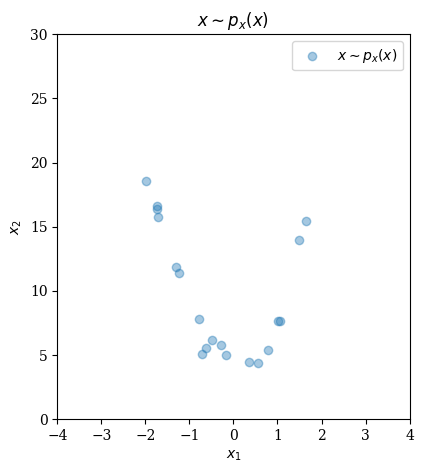

In [426]:
plot_num = min(n_train, 100)

fig = figure(figsize=(10,5));
subplot(1,2,1); title(L"x \sim p_x(x)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{x}(x)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

# Linear inverse problem with Gaussian additive noise

As a stylized example, we will solve an inverse problem given linear measurements of a model $x$ through a compressive sensing operator $A$. We will also add gaussian additive noise and the result will be our observed data.   
$$y = Ax + \epsilon$$

Even though we will choose an $A$ that will be invertible, the added noise makes this problem ill-posed. Therefore for a given datapoint $y$ there is not a single model $x$ which solves the inverse problem. Instead there is a whole distribution of models $p(x|y)$, the conditional distribution. In this context, this is also called the posterior distribution. 

Note: we could also use a non-linear operator.

First we make an our linear measurement operator:

In [427]:
# Random seed
seed = 2
Random.seed!(seed)

# Linear forward operator
A = randn(Float32,2,2)
A = A / (2*opnorm(A)); 

In [428]:
@which opnorm

LinearAlgebra

Then use this operator to make training data $Y_{train}$

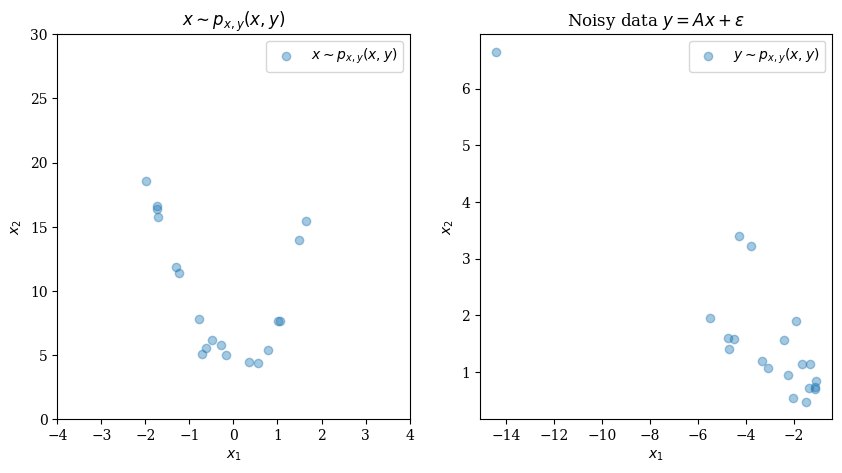

In [429]:
Y_train = reshape(A*reshape(X_train, :, n_train), nx, ny, n_in, n_train)
Y_train += .2f0*randn(Float32, nx, ny, n_in, n_train)

if use_cat == true
    Y_train = cat([Y_train for _ in 1:repitition]..., dims=4);
    X_train = cat([X_train for _ in 1:repitition]..., dims=4);
end

fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p_{x,y}(x,y)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Noisy data $y = Ax + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Training a conditional normalizing flow. 

<font color=orange>A conditional normalizing flow is trained by learning the joint distribution $p(x,y)$ this is done in the same way as a non-conditional normalizing flow is trained by minimizing the negative log likelihood (Refer to Tutorial notebook 01 for more details.)</font>

In [430]:
function loss(H, X, Y)
    batch_size = size(X)[end] 
    
    Zx, Zy, lgdet = H.forward(X, Y)
    l2_loss = 0.5*norm(tensor_cat(Zx, Zy))^2 / batch_size  #likelihood under Normal Gaussian training 
    
    #gradients under Normal Gaussian training
    dZx = Zx / batch_size 
    dZy = Zy / batch_size 
    
    H.backward(dZx, dZy, Zx, Zy) #sets gradients of G wrt output and also logdet terms
    
    return (l2_loss, lgdet)
end

loss (generic function with 1 method)

In [431]:
@which tensor_cat

InvertibleNetworks

In [432]:
# Define network

n_hidden = 64
batchsize = 64
depth = 10

# Construct HINT network
H = NetworkConditionalHINT(n_in, n_hidden, depth; k1=1, k2=1, p1=0, p2=0)

# Training
maxiter = 900
lr      = 5f-4
lr_decay_step = 90

#compose adam optimizer with exponential learning rate decay 
opt = Flux.Optimiser(ExpDecay(lr, .9f0, lr_decay_step, 1f-6), Flux.ADAM(lr))

loss_l2_list    = zeros(maxiter)
loss_lgdet_list = zeros(maxiter)

for j=1:maxiter

    # Evaluate objective and gradients
    Y_train = reshape(A*reshape(X_train, :, n_train), nx, ny, n_in, n_train)
    Y_train += .2f0*randn(Float32, nx, ny, n_in, n_train)

    if use_cat == true
        Y_train = cat([Y_train for _ in 1:repitition]..., dims=4);
        X_train = cat([X_train for _ in 1:repitition]..., dims=4);
    end
    
    X = sample_banana(batchsize)
    Y = reshape(A*reshape(X, :, batchsize), nx, ny, n_in, batchsize)
    Y += .2f0*randn(Float32, nx, ny, n_in, batchsize)

    losses = loss(H, X, Y)
    loss_l2_list[j]    = losses[1]
    loss_lgdet_list[j] = losses[2]
    
    # print("Iter : iteration=", j, "/", maxiter, ", batch=", 
    #         "; f l2 = ",   loss_l2_list[j], 
    #         "; f lgdet = ",loss_lgdet_list[j], 
    #         "; f nll objective = ",loss_l2_list[j] - loss_lgdet_list[j], "\n")

    # Update params
    for p in get_params(H)
        Flux.update!(opt, p.data, p.grad)
    end
end

## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $Zx, Zy = H_{\theta}(Z,Y)$ with qq plots 
- as a heuristic simply observe $Zx, Zy = H_{\theta}(X, Y)$ until it looks normal under the eyeball norm. 

Note: joint distributions are harder to learn than marginal distributions. There are a few reasons including the larger dimensionality and the fact that learning a joint distribution implicitly also learns a conditional distribution. 

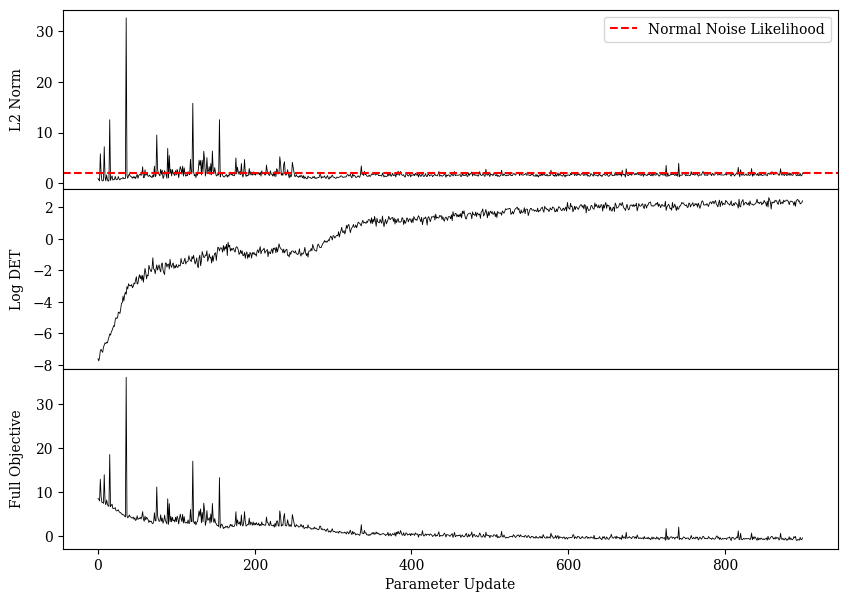

PyObject Text(0.5, 24.000000000000007, 'Parameter Update')

In [433]:
gt_l2 = 0.5*nx*ny*n_in*2 #l2 norm of noise. Note: extra 2 factor since learning a 2 rv. joint distribution

fig, axs = subplots(3, 1, sharex=true, figsize=(10,7))
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.05, 0.5)
axs[1].legend()

axs[2].plot(loss_lgdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("Log DET") 
axs[2].yaxis.set_label_coords(-0.05, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.05, 0.5)
axs[3].set_xlabel("Parameter Update") 

## Testing a Conditional Normalizing Flow 

The first step in testing a normalizing flow is to understand what prior it has learned. In this case, we trained our network to generate samples from a joint distribution so we will first check that these generative samples look like 
 
We start with normal gaussian variables $Zx, Zy \sim N(0, I)$

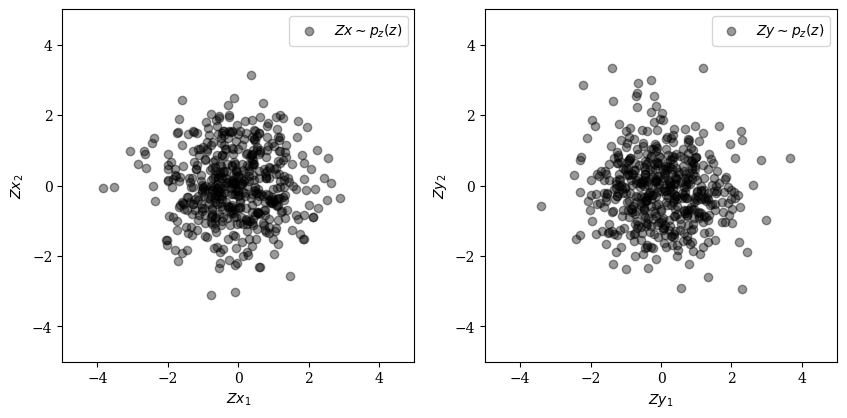

In [434]:
num_test_samples = 500;
Zx_test = randn(Float32,nx,ny,n_in, num_test_samples);
Zy_test = randn(Float32,nx,ny,n_in, num_test_samples);

fig = figure(figsize=(10,5)); 
ax1 = subplot(1,2,1)
scatter(Zx_test[1,1,1,:], Zx_test[1,1,2,:]; alpha=0.4, color="black", label = L"Zx \sim p_{z}(z)");
xlabel(L"Zx_1"); ylabel(L"Zx_2"); xlim(-5,5); ylim(-5,5);
legend(); ax1.set_aspect(1);

ax2 = subplot(1,2,2)
scatter(Zy_test[1,1,1,:], Zy_test[1,1,2,:]; alpha=0.4, color="black", label = L"Zy \sim p_{z}(z)");
xlabel(L"Zy_1"); ylabel(L"Zy_2"); xlim(-5,5); ylim(-5,5);
legend(); ax2.set_aspect(1);

Make generative samples from the joint distribution by passing both Z variables through the inverse network $ x,  y = H^{-1}_\theta(Zx,Zy)$ 

In [435]:
X_test, Y_test = H.inverse(Zx_test, Zy_test);

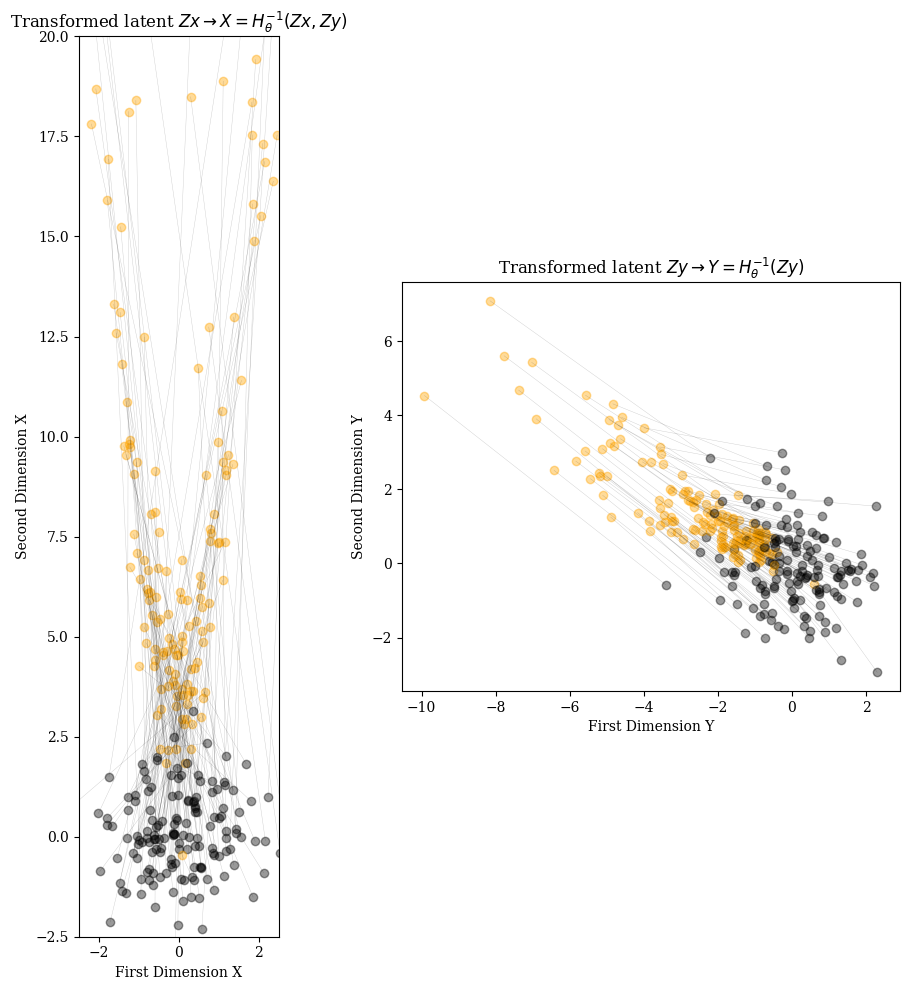

In [436]:
trans_num = 150
start_points = [(Zx_test[1,1,1,i], Zx_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:trans_num]

# Plot transformed Latent Zx
fig = figure(figsize=(10,10));
ax = fig.add_subplot(1,2,1); title(L"Transformed latent $Zx \rightarrow X=H^{-1}_\theta(Zx, Zy)$");

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension X"); ylabel("Second Dimension X");
ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

# Plot transformed Latent Zy
start_points = [(Zy_test[1,1,1,i], Zy_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(Y_test[1,1,1,i], Y_test[1,1,2,i]) for i in 1:trans_num]

ax = fig.add_subplot(1,2,2); title(L"Transformed latent $Zy \rightarrow Y=H^{-1}_\theta(Zy)$");
for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension Y"); ylabel("Second Dimension Y");
ax.set_aspect(1)

tight_layout()

Visually compare generative joint samples with joint samples from the ground truth density $x, y \sim p(x,y) $

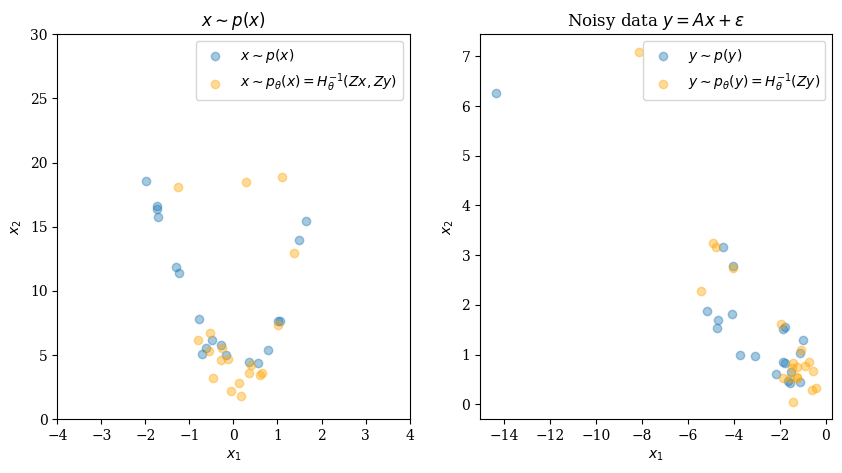

In [437]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p(x)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x)");
scatter(X_test[1,1,1,1:plot_num], X_test[1,1,2,1:plot_num]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = H_\theta^{-1}(Zx, Zy)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Noisy data $y = Ax + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(y)");
scatter(Y_test[1,1,1,1:plot_num], Y_test[1,1,2,1:plot_num]; alpha=0.4, color="orange", label = L"y \sim p_{\theta}(y) = H_\theta^{-1}(Zy)");
xlabel(L"x_1"); ylabel(L"x_2");
legend();
savefig("08_plots/generated_sample_seed=$seed" * "_n_train=$n_train" * "_tot_train=$tot_train")

## Test inference of inverse problem given noisy data

After verifying that training was successful we can proceed to perform inference of the inverse problem. We will first observe a single data $y$:

In [438]:
x_star  = sample_banana(1);
y_obs = reshape(A*vec(x_star), nx, ny, n_in, 1);
y_obs += .2f0*randn(Float32, size(y_obs));

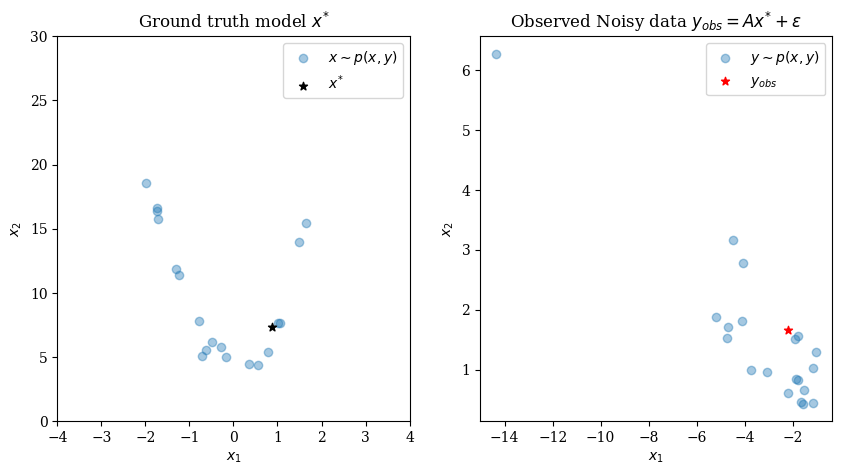

In [439]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Form conditional distribution given observed data $p(x|y_{obs})$

Remember that the y-lane in HINT is completely independent of the x-lane. This functionality is implemented in  ``H.forward_Y`` which we will call on our observed data to get the corresponding latent variable $z_y$.


In [440]:
zy_fixed = H.forward_Y(y_obs);

Then we can sample directly from the conditional aka posterior distribution $x \sim p(x|y_{obs})$ We do this by resampling $z_x \sim N(0,I)$ and calling the inverse network $H^{-1}(z_x, z_y)$

In [441]:
#fix zy and resample zx many times to generate samples from the conditional distribution p(x|y)
cond_sampling_size = 50
Zx = randn(Float32, nx, ny, n_in, cond_sampling_size)
X_post = H.inverse(Zx, zy_fixed.*ones(Float32, nx, ny, n_in, cond_sampling_size))[1];

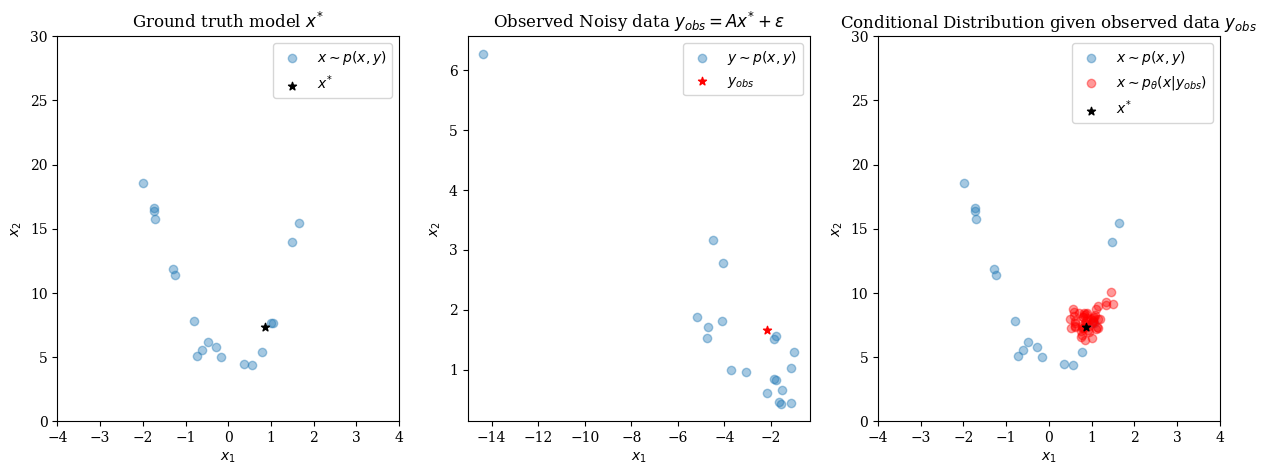

In [442]:
fig = figure(figsize=(15,5)); 
subplot(1,3,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,3,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

subplot(1,3,3); title(L"Conditional Distribution given observed data $y_{obs}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(X_post[1,1,1,:], X_post[1,1,2,:]; alpha=0.4, color="red", label = L"x \sim p_{\theta}(x | y_{obs})");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*",color="black",  label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend()

savefig("08_plots/posterior_seed=$seed" * "_n_train=$n_train" * "_tot_train=$tot_train")